## 1. Importation et préparation des données

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [9]:
application_test = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/application_test.csv', sep=',', encoding='ISO-8859-1')
application_train = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/application_train.csv', sep=',', encoding='ISO-8859-1')

In [10]:
application_test['type_data'] = 'test'
application_train['type_data'] = 'train'

In [11]:
print("application_test -  rows:",application_test.shape[0]," columns:", application_test.shape[1])
print("application_train -  rows:",application_train.shape[0]," columns:", application_train.shape[1])

application_test -  rows: 48744  columns: 122
application_train -  rows: 307511  columns: 123


In [12]:
# Fonction pour afficher les colonnes et les premières valeurs d'un DataFrame
def display_columns(df, df_name):
    display(f"--- {df_name} ---")
    display(list(df.columns))  

pd.set_option('display.max_rows', None)
# Appeler la fonction pour chaque DataFrame
display_columns(application_test, "application_test")
display_columns(application_train, "application_train")

'--- application_test ---'

['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEAR

'--- application_train ---'

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [13]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    # Exclure la colonne 'Type_data' des colonnes catégorielles
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # Encodage one-hot pour les autres colonnes catégorielles
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = application_train.copy()
    test_df = application_test.copy()

    # Combine train and test datasets
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df], axis=0).reset_index(drop=True)

    # Assurer que 'type_data' est catégorielle
    df['type_data'] = df['type_data'].astype('category')

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # Categorical features with One-Hot encode (excluding 'Type_data')
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # Clean up
    del test_df
    gc.collect()

    return df


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/bureau.csv', sep=',', encoding='ISO-8859-1')
    bb = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/bureau_balance.csv', sep=',', encoding='ISO-8859-1')
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/previous_application.csv', sep=',', encoding='ISO-8859-1')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos= pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/POS_CASH_balance.csv', sep=',', encoding='ISO-8859-1')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/installments_payments.csv', sep=',', encoding='ISO-8859-1')
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc= pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/credit_card_balance.csv', sep=',', encoding='ISO-8859-1')
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


In [14]:
# Appeler les fonctions de prétraitement
train_test_df = application_train_test()           # application_train.csv et application_test.csv
bureau_agg_df = bureau_and_balance()               # bureau.csv et bureau_balance.csv
prev_app_agg_df = previous_applications()          # previous_application.csv
pos_cash_agg_df = pos_cash()                       # POS_CASH_balance.csv
installments_agg_df = installments_payments()      # installments_payments.csv
credit_card_agg_df = credit_card_balance()         # credit_card_balance.csv

# Fusionner les différents jeux de données avec 'train_test_df'
# Le DataFrame principal est `train_test_df`, et nous fusionnons chaque ensemble basé sur `SK_ID_CURR`.
train_test_df = train_test_df.merge(bureau_agg_df, on='SK_ID_CURR', how='left')
train_test_df = train_test_df.merge(prev_app_agg_df, on='SK_ID_CURR', how='left')
train_test_df = train_test_df.merge(pos_cash_agg_df, on='SK_ID_CURR', how='left')
train_test_df = train_test_df.merge(installments_agg_df, on='SK_ID_CURR', how='left')
train_test_df = train_test_df.merge(credit_card_agg_df, on='SK_ID_CURR', how='left')

# Gérer les valeurs infinies après la fusion
train_test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

Train samples: 307511, test samples: 48744


In [15]:
# Vérifier si SK_ID_CURR contient uniquement des valeurs uniques
unique_values = train_test_df['SK_ID_CURR'].nunique()

# Comparer avec le nombre total de lignes
total_values = len(train_test_df['SK_ID_CURR'])

if unique_values == total_values:
    print("Toutes les valeurs de SK_ID_CURR sont uniques.")
else:
    print(f"Il y a {total_values - unique_values} doublons dans SK_ID_CURR.")

Toutes les valeurs de SK_ID_CURR sont uniques.


In [16]:
# Sélectionner uniquement les colonnes numériques
colonnes_numeriques = train_test_df.select_dtypes(include=[np.number])

# Vérifier si des valeurs infinies existent dans les colonnes numériques
valeurs_infinies = np.isinf(colonnes_numeriques)

# Compter le nombre total de valeurs infinies
nombre_de_valeurs_infinies = valeurs_infinies.sum().sum()

# Compter le nombre de lignes contenant des valeurs infinies
lignes_infinies = valeurs_infinies.any(axis=1)  # Renvoie un tableau booléen par ligne
nombre_de_lignes_infinies = lignes_infinies.sum()

print(f"Nombre total de valeurs infinies : {nombre_de_valeurs_infinies}")
print(f"Nombre de lignes contenant des valeurs infinies : {nombre_de_lignes_infinies}")


Nombre total de valeurs infinies : 0
Nombre de lignes contenant des valeurs infinies : 0


## 2. Exploratory data analysis

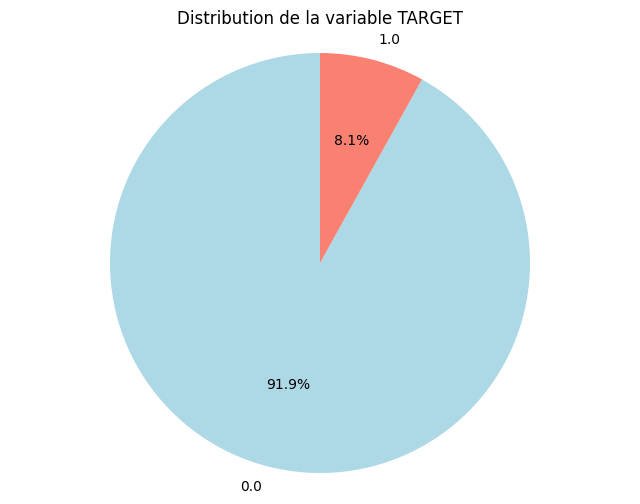

In [17]:
# Calculer la distribution de la variable TARGET
target_distribution = train_test_df['TARGET'].value_counts()

# Créer le camembert
plt.figure(figsize=(8, 6))
plt.pie(target_distribution, labels=target_distribution.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
plt.title('Distribution de la variable TARGET')
plt.axis('equal')  # Pour s'assurer que le camembert est un cercle
plt.show()

Ces données indiquent un problème de déséquilibre pour la variable Target, avec un nombre nettement supérieur de prêts remboursés à temps (91.9%) par rapport aux prêts non remboursés (8.1%). Pour corriger ce déséquilibre lors de l'utilisation de modèles d'apprentissage automatique plus avancés, nous pourrons ajuster la pondération des classes en fonction de leur fréquence dans les données.

### Corrélations

In [18]:
# Calculer les corrélations avec la variable TARGET
corr_with_target = train_test_df.corr()['TARGET'].sort_values(ascending=False)

# Filtrer les variables ayant une corrélation significative avec TARGET
threshold = 0.05  # définir le seuil
significant_vars = corr_with_target[abs(corr_with_target) > threshold].index.tolist()

# Créer un sous-ensemble du DataFrame avec ces variables
df_significant = train_test_df[significant_vars]

# Calculer la matrice de corrélation pour ces variables
corr_matrix = df_significant.corr().abs()

# Supprimer les variables corrélées entre elles (Multicolinéarité)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Trouver les variables ayant une corrélation supérieure au seuil
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]

# Supprimer les variables corrélées entre elles
df_reduced = df_significant.drop(columns=to_drop)

# Créer un DataFrame sans valeurs manquantes pour le calcul du VIF
X = df_reduced.dropna().assign(constant=1)

# Calculer les VIF pour chaque variable sur les données sans valeurs manquantes
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filtrer les variables ayant un VIF élevé (par exemple > 5)
final_vars = vif_data[vif_data['VIF'] < 5]['feature'].tolist()

# Supprimer la constante du résultat final si présente
if 'constant' in final_vars:
    final_vars.remove('constant')

# Les variables finales sélectionnées
print("Variables sélectionnées :", final_vars)

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_97026/4233801731.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_with_target = train_test_df.corr()['TARGET'].sort_values(ascending=False)


Variables sélectionnées : ['TARGET', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'CC_CNT_DRAWINGS_CURRENT_MAX', 'BURO_DAYS_CREDIT_MEAN', 'CC_AMT_BALANCE_MEAN', 'DAYS_BIRTH', 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'BURO_CREDIT_ACTIVE_Active_MEAN', 'DAYS_EMPLOYED', 'REFUSED_DAYS_DECISION_MAX', 'CC_AMT_BALANCE_MIN', 'ACTIVE_DAYS_CREDIT_MEAN', 'CC_CNT_DRAWINGS_ATM_CURRENT_MAX', 'CC_MONTHS_BALANCE_MEAN', 'BURO_STATUS_1_MEAN_MEAN', 'CC_CNT_DRAWINGS_ATM_CURRENT_VAR', 'REGION_RATING_CLIENT_W_CITY', 'CC_AMT_DRAWINGS_CURRENT_MEAN', 'NAME_INCOME_TYPE_Working', 'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN', 'PREV_CODE_REJECT_REASON_SCOFR_MEAN', 'DAYS_LAST_PHONE_CHANGE', 'APPROVED_DAYS_DECISION_MIN', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY', 'REFUSED_HOUR_APPR_PROCESS_START_MIN', 'CODE_GENDER', 'BURO_STATUS_C_MEAN_MEAN', 'NAME_EDUCATION_TYPE_Higher education', 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']


In [19]:
# Créer le nouveau DataFrame avec les variables sélectionnées et la variable 'Type_data'
final_vars_with_type_data = final_vars + ['SK_ID_CURR'] + ['type_data']
train_test_df_2 = train_test_df[final_vars_with_type_data]

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_97026/2060588733.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix_2 = train_test_df_2.corr()


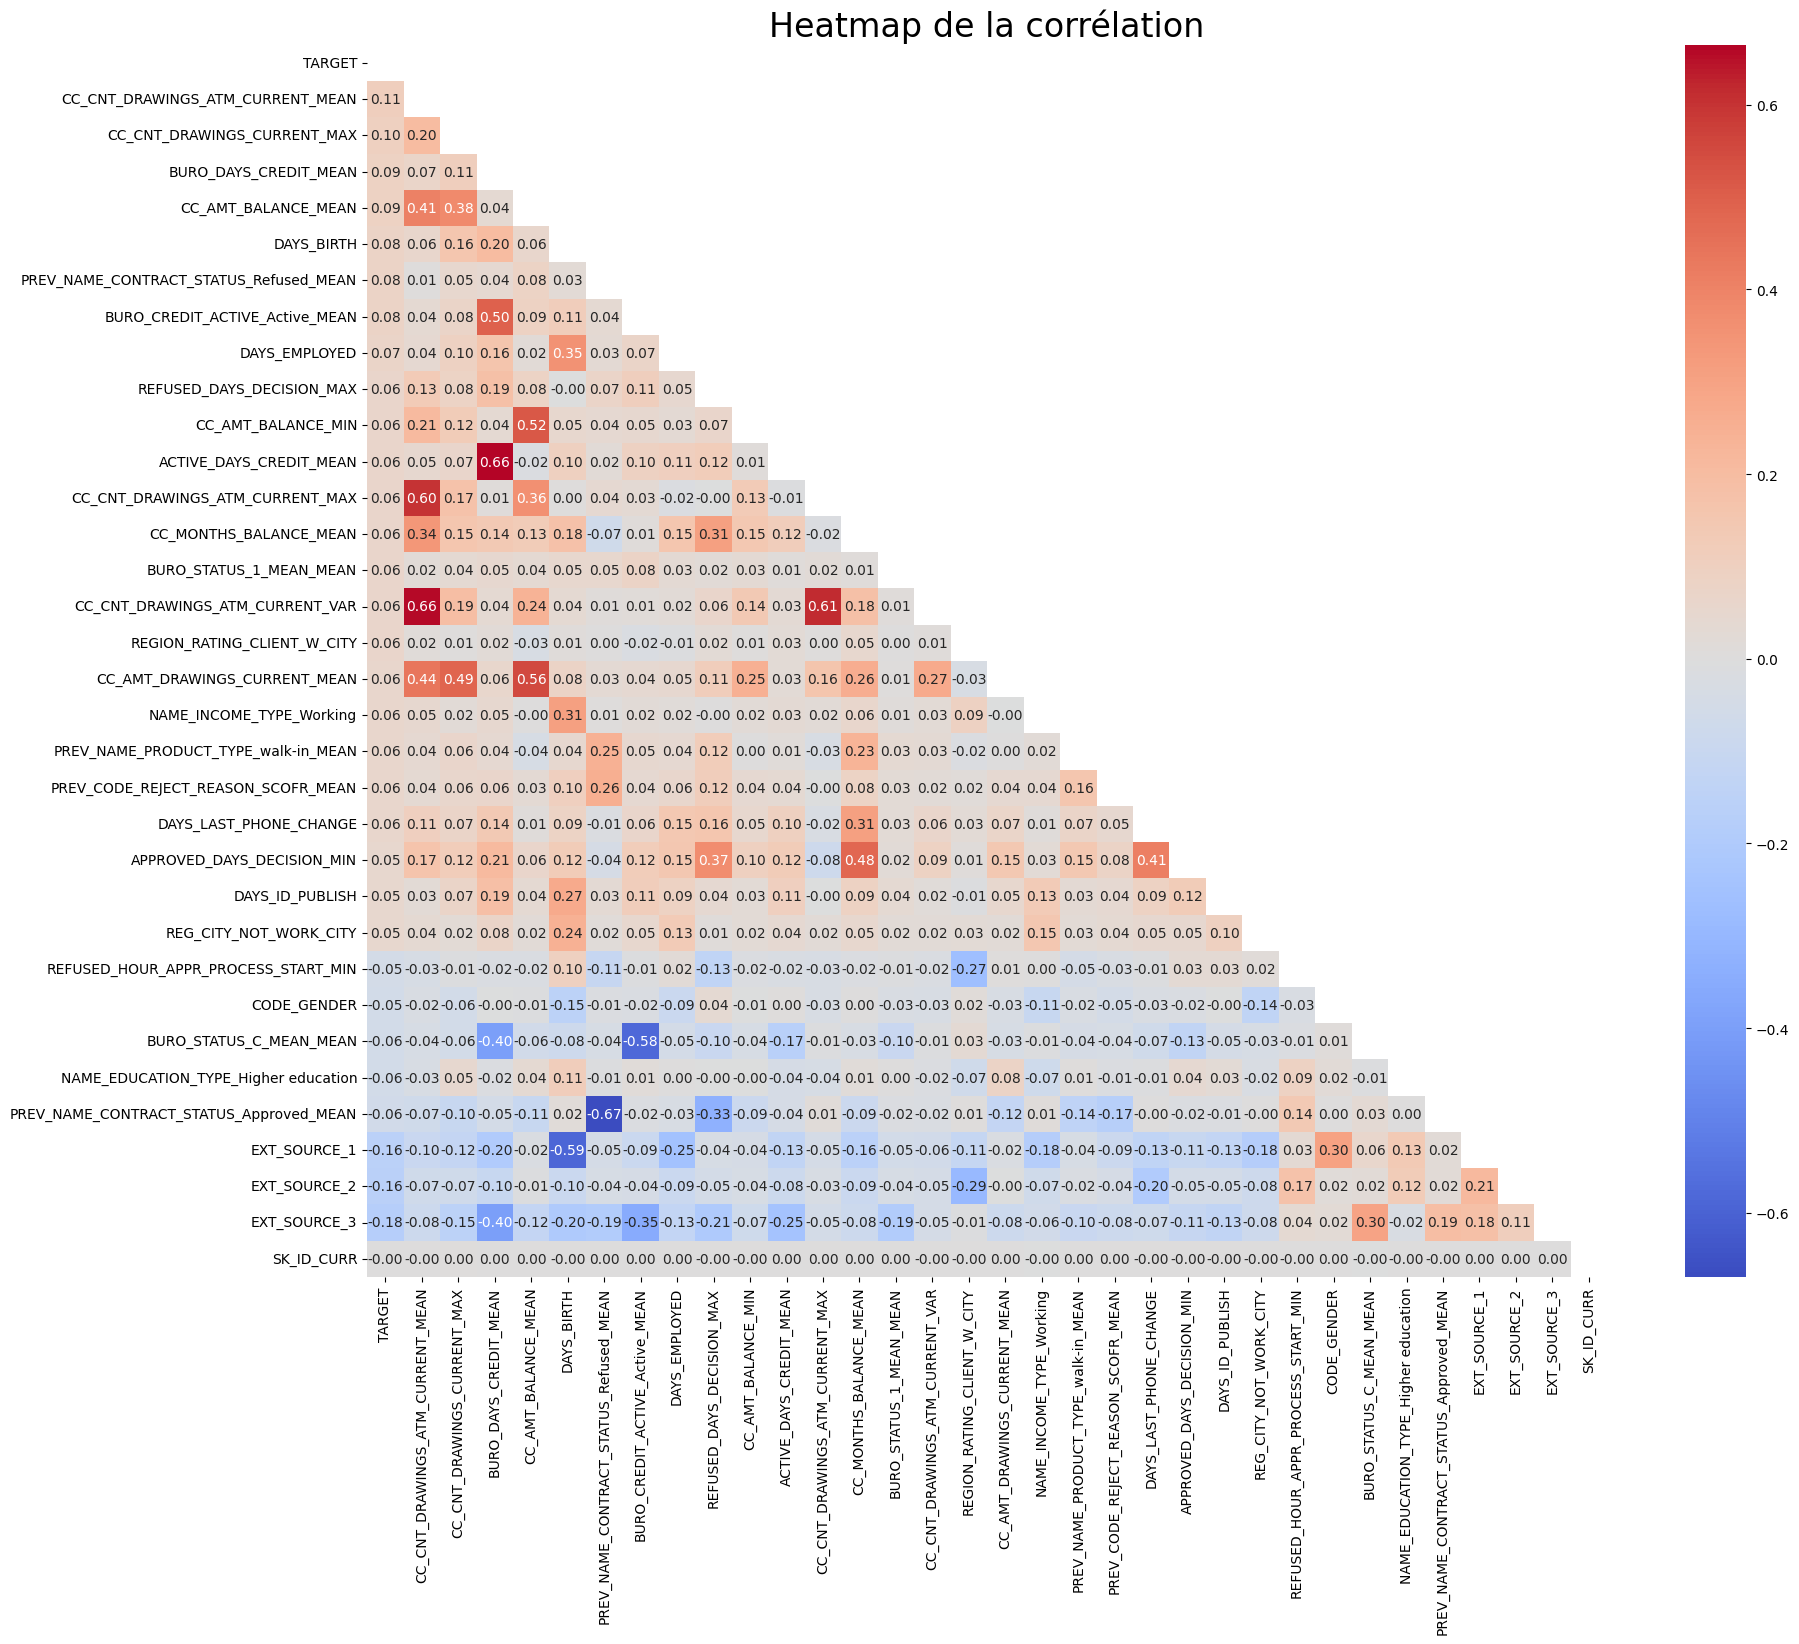

In [20]:
# Calculer la matrice de corrélation pour les variables sélectionnées
corr_matrix_2 = train_test_df_2.corr()

# Masquer la moitié inférieure de la matrice de corrélation
mask = np.triu(np.ones_like(corr_matrix_2, dtype=bool))

# Tracer la heatmap avec le masque
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix_2, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Heatmap de la corrélation", fontsize=24)
plt.show()

In [21]:
train_test_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 356254
Data columns (total 35 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   TARGET                                   307511 non-null  float64 
 1   CC_CNT_DRAWINGS_ATM_CURRENT_MEAN         72194 non-null   float64 
 2   CC_CNT_DRAWINGS_CURRENT_MAX              103558 non-null  float64 
 3   BURO_DAYS_CREDIT_MEAN                    305811 non-null  float64 
 4   CC_AMT_BALANCE_MEAN                      103558 non-null  float64 
 5   DAYS_BIRTH                               356255 non-null  int64   
 6   PREV_NAME_CONTRACT_STATUS_Refused_MEAN   338857 non-null  float64 
 7   BURO_CREDIT_ACTIVE_Active_MEAN           305811 non-null  float64 
 8   DAYS_EMPLOYED                            291607 non-null  float64 
 9   REFUSED_DAYS_DECISION_MAX                118277 non-null  float64 
 10  CC_AMT_BALANCE_MIN  

In [22]:
# Séparer le DataFrame selon la variable type_data
train_df_2 = train_test_df_2[train_test_df_2['type_data'] == 'train']
test_df_2 = train_test_df_2[train_test_df_2['type_data'] == 'test']

# Enregistrer les DataFrames sous forme de fichiers CSV
train_df_2.to_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/train_df_2.csv', index=False)
test_df_2.to_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/test_df_2.csv', index=False)

print("Les fichiers CSV ont été enregistrés avec succès.")

Les fichiers CSV ont été enregistrés avec succès.


In [33]:
types_df = pd.DataFrame(train_df_2.dtypes).reset_index()
types_df.columns = ['Column Name', 'Data Type']
types_df


,Column Name,Data Type
0,TARGET,float64
1,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,float64
2,CC_CNT_DRAWINGS_CURRENT_MAX,float64
3,BURO_DAYS_CREDIT_MEAN,float64
4,CC_AMT_BALANCE_MEAN,float64
5,DAYS_BIRTH,int64
6,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,float64
7,BURO_CREDIT_ACTIVE_Active_MEAN,float64
8,DAYS_EMPLOYED,float64
9,REFUSED_DAYS_DECISION_MAX,float64


In [24]:
nan_count = train_test_df_2['TARGET'].isna().sum()
print(f"Nombre de NaN dans TARGET : {nan_count}")

Nombre de NaN dans TARGET : 48744


#### Valeurs manquantes

In [25]:
# Calculer le nombre de valeurs manquantes pour chaque colonne
missing_values = train_test_df_2.isnull().sum()

# Calculer le pourcentage de valeurs manquantes pour chaque colonne
missing_percentage = 100 * missing_values / len(train_test_df)

# Créer un DataFrame avec le nombre et le pourcentage de valeurs manquantes
missing_df = pd.DataFrame({'Missing Values': missing_values, '% of Total Values': missing_percentage})

# Trier les colonnes par pourcentage de valeurs manquantes en ordre décroissant
missing_df_sorted = missing_df[missing_df['Missing Values'] > 0].sort_values('% of Total Values', ascending=False).round(2)

# Afficher le résultat
missing_df_sorted


,Missing Values,% of Total Values
CC_CNT_DRAWINGS_ATM_CURRENT_VAR,284563,79.88
CC_CNT_DRAWINGS_ATM_CURRENT_MAX,284061,79.74
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,284061,79.74
CC_CNT_DRAWINGS_CURRENT_MAX,252697,70.93
CC_AMT_BALANCE_MEAN,252697,70.93
CC_AMT_DRAWINGS_CURRENT_MEAN,252697,70.93
CC_AMT_BALANCE_MIN,252697,70.93
CC_MONTHS_BALANCE_MEAN,252697,70.93
REFUSED_HOUR_APPR_PROCESS_START_MIN,237978,66.80
REFUSED_DAYS_DECISION_MAX,237978,66.80


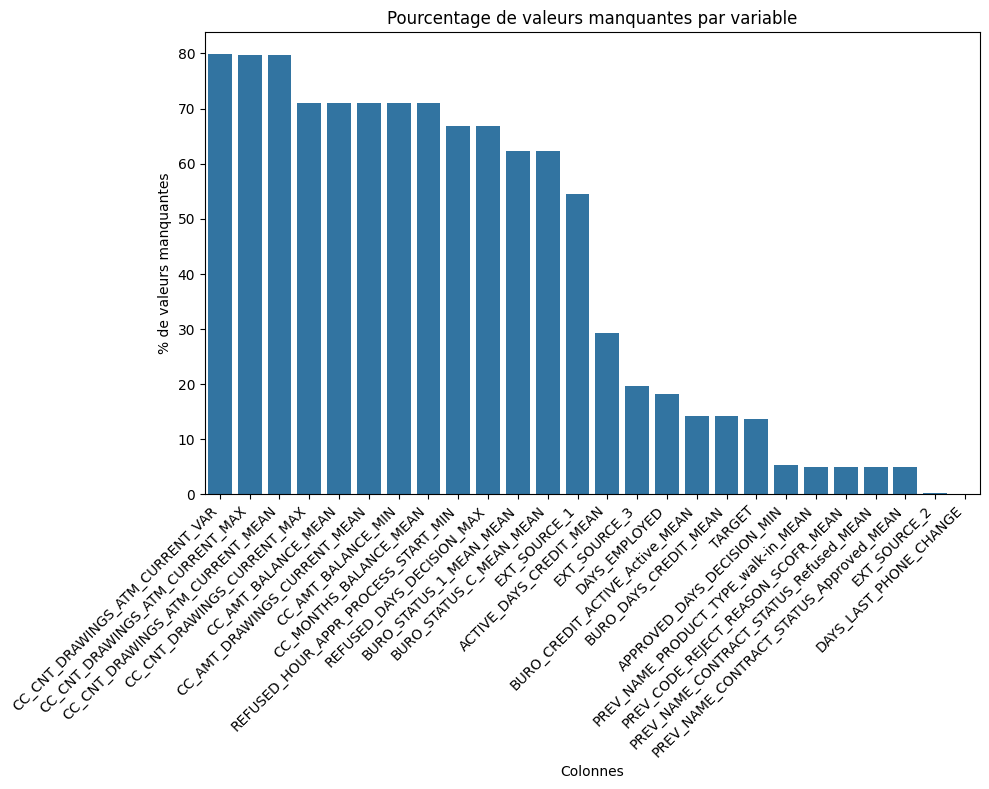

In [26]:
# Configurer la taille de la figure
plt.figure(figsize=(10, 6))

# Créer un diagramme en barres avec Seaborn pour les valeurs manquantes
sns.barplot(x=missing_df_sorted.index, y=missing_df_sorted['% of Total Values'])

# Ajouter des labels et un titre
plt.xticks(rotation=45, ha='right')  # Rotation et alignement des étiquettes de l'axe x
plt.xlabel('Colonnes')
plt.ylabel('% de valeurs manquantes')
plt.title('Pourcentage de valeurs manquantes par variable')

# Afficher le graphique
plt.show()

Avant de passer à la phase d’entraînement des modèles, il sera crucial de traiter les colonnes avec des valeurs manquantes afin de garantir la qualité des données et d'améliorer les performances du modèle.

### Valeurs nulles

In [27]:
# Calculer le pourcentage de valeurs nulles par variable
pourcentage_valeurs_nulles = train_test_df.isnull().mean() * 100

# Trier par ordre décroissant
pourcentage_valeurs_nulles_tries = pourcentage_valeurs_nulles.sort_values(ascending=False)

# Afficher le résultat
pourcentage_valeurs_nulles_tries

REFUSED_AMT_DOWN_PAYMENT_MIN                                             85.233891
REFUSED_RATE_DOWN_PAYMENT_MIN                                            85.233891
REFUSED_RATE_DOWN_PAYMENT_MEAN                                           85.233891
REFUSED_AMT_DOWN_PAYMENT_MEAN                                            85.233891
REFUSED_RATE_DOWN_PAYMENT_MAX                                            85.233891
REFUSED_AMT_DOWN_PAYMENT_MAX                                             85.233891
REFUSED_APP_CREDIT_PERC_VAR                                              83.657773
CC_AMT_PAYMENT_CURRENT_VAR                                               79.901475
CC_AMT_DRAWINGS_ATM_CURRENT_VAR                                          79.876212
CC_CNT_DRAWINGS_POS_CURRENT_VAR                                          79.876212
CC_AMT_DRAWINGS_POS_CURRENT_VAR                                          79.876212
CC_CNT_DRAWINGS_ATM_CURRENT_VAR                                          79.876212
CC_A

## Modèles

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import mlflow
import time
from scipy.stats import uniform, randint  # Assurez-vous d'importer ces deux fonctions


In [36]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from joblib import dump
from sklearn.metrics import confusion_matrix, roc_auc_score
import mlflow
from scipy.stats import uniform, randint

In [38]:
# Séparer l'ensemble d'entraînement et de test
train_df_2 = train_test_df_2[train_test_df_2['type_data'] == "train"]
test_df_2 = train_test_df_2[train_test_df_2['type_data'] == "test"]

train_df_2 = train_df_2.drop(columns=['SK_ID_CURR'])
train_df_2 = train_df_2.drop(columns='type_data')

# Séparation des caractéristiques (X) et de la cible (y) pour l'entraînement
X = train_df_2.drop(columns='TARGET')
y = train_df_2['TARGET']

# Séparation du jeu d'entraînement en entraînement et validation (80% - 20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Séparation de X_temp en validation et test (50% - 50% de l'ensemble temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Sélectionner uniquement les colonnes quantitatives (numériques)
quantitative_columns = X_train.select_dtypes(include=[np.number]).columns

# Initialiser l'imputer avec la stratégie 'median'
imputer = SimpleImputer(strategy='median')

# Appliquer l'imputer sur les colonnes quantitatives du jeu d'entraînement et de validation
X_train[quantitative_columns] = imputer.fit_transform(X_train[quantitative_columns])
X_val[quantitative_columns] = imputer.transform(X_val[quantitative_columns])
X_test[quantitative_columns] = imputer.transform(X_test[quantitative_columns])

# Application de SMOTE uniquement sur le jeu d'entraînement pour gérer le déséquilibre des classes
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Standardiser les données avec MinMaxScaler
scaler = MinMaxScaler()

# Appliquer la standardisation sur le jeu d'entraînement, de validation et de test
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Vérification des dimensions
print(f"Dimensions de X_train : {X_train.shape}")
print(f"Dimensions de X_val : {X_val.shape}")
print(f"Dimensions de X_test : {X_test.shape}")

Dimensions de X_train : (452264, 33)
Dimensions de X_val : (30751, 33)
Dimensions de X_test : (30752, 33)


In [40]:
# Fonction pour calculer le score métier
def business_score(y_true, y_pred_proba, threshold=0.5, fn_cost=10, fp_cost=1):
    y_pred = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = (fn * fn_cost) + (fp * fp_cost)
    return total_cost

# Fonction pour évaluer les modèles
def evaluate_model(model, X_train, y_train, X_val, y_val, threshold=0.5):
    start_time = time.time()
    model.fit(X_train, y_train)
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    
    auc_score = roc_auc_score(y_val, y_val_pred_proba)
    business_cost = business_score(y_val, y_val_pred_proba, threshold=threshold)
    exec_time = time.time() - start_time

    return {
        'AUC': auc_score,
        'Business Cost': business_cost,
        'Execution Time': exec_time
    }

# Fonction pour optimiser le seuil
def find_optimal_threshold(model, X_val, y_val, fn_cost=10, fp_cost=1):
    best_threshold = 0.5
    best_cost = float('inf')
    
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    
    for threshold in np.arange(0, 1, 0.01):
        cost = business_score(y_val, y_val_pred_proba, threshold, fn_cost, fp_cost)
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold
    
    return best_threshold, best_cost

# Modèles à tester
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(eval_metric='auc'),
    'CatBoost': CatBoostClassifier(silent=True),
    'Dummy': DummyClassifier(strategy='stratified')
}

# Paramètres à tester pour chaque modèle avec RandomizedSearchCV
param_dist = {
    'LogisticRegression': {
        'C': uniform(0.01, 10),  
        'solver': ['lbfgs', 'liblinear']
    },
    'LightGBM': {
        'num_leaves': randint(20, 50),
        'learning_rate': uniform(0.01, 0.3),
        'n_estimators': randint(100, 200)
    },
    'XGBoost': {
        'learning_rate': uniform(0.01, 0.3),
        'n_estimators': randint(100, 200),
        'max_depth': randint(3, 10)
    },
    'CatBoost': {
        'depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'iterations': randint(100, 200)
    },
    'Dummy': {
        'strategy': ['stratified', 'most_frequent']
    }
}

# DataFrame pour stocker les résultats
results = []


# Initialiser l'expérience MLflow
mlflow.set_experiment('credit_scoring_experiment')

# Boucle sur les modèles
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"Optimisation pour {model_name}")
        
        # RandomizedSearchCV pour optimiser les hyperparamètres
        search_cv = RandomizedSearchCV(
            model,
            param_distributions=param_dist[model_name],
            n_iter=10,
            cv=3,
            n_jobs=1,
            random_state=42
        )
        
        search_cv.fit(X_train, y_train)
        best_model = search_cv.best_estimator_
        
        # Enregistrer les hyperparamètres dans MLflow
        mlflow.log_params(search_cv.best_params_)
        
        # Évaluer les métriques
        eval_metrics = evaluate_model(best_model, X_train, y_train, X_val, y_val)
        best_threshold, best_cost = find_optimal_threshold(best_model, X_val, y_val)
        eval_metrics['Optimal Threshold'] = best_threshold
        eval_metrics['Business Cost with Optimal Threshold'] = best_cost
        eval_metrics['Model'] = model_name
        eval_metrics['Best Params'] = search_cv.best_params_
        
        results.append(eval_metrics)
        
        # Enregistrer les métriques dans MLflow
        mlflow.log_metric("AUC", eval_metrics['AUC'])
        mlflow.log_metric("Business Cost", eval_metrics['Business Cost'])
        mlflow.log_metric("Business Cost with Optimal Threshold", best_cost)
        mlflow.log_metric("Execution Time", eval_metrics['Execution Time'])
        
        # Enregistrer le modèle dans MLflow
        mlflow.sklearn.log_model(best_model, model_name)
        
        # Enregistrer dans le Model Registry
        model_uri = f"runs:/{mlflow.active_run().info.run_id}/{model_name}"
        mlflow.register_model(model_uri, "CreditScoringModel")


# Rassembler les résultats dans un DataFrame
df_results = pd.DataFrame(results)
df_results


Optimisation pour LogisticRegression


2024/10/07 18:06:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'CreditScoringModel'.
Created version '1' of model 'CreditScoringModel'.


Optimisation pour LightGBM
[LightGBM] [Info] Number of positive: 150755, number of negative: 150754
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8409
[LightGBM] [Info] Number of data points in the train set: 301509, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000007
[LightGBM] [Info] Start training from score 0.000007
[LightGBM] [Info] Number of positive: 150754, number of negative: 150755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8407
[LightGBM] [Info] Number of data points in the train set: 301509, number of used 

2024/10/07 18:11:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'CreditScoringModel' already exists. Creating a new version of this model...
Created version '2' of model 'CreditScoringModel'.


Optimisation pour XGBoost


2024/10/07 18:16:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'CreditScoringModel' already exists. Creating a new version of this model...
Created version '3' of model 'CreditScoringModel'.


Optimisation pour CatBoost


2024/10/07 18:28:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'CreditScoringModel' already exists. Creating a new version of this model...
Created version '4' of model 'CreditScoringModel'.
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Optimisation pour Dummy


2024/10/07 18:28:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'CreditScoringModel' already exists. Creating a new version of this model...
Created version '5' of model 'CreditScoringModel'.


,AUC,Business Cost,Execution Time,Optimal Threshold,Business Cost with Optimal Threshold,Model,Best Params
0,0.742846,17002,11.264653,0.50,17002,LogisticRegression,"{'C': 8.334426408004218, 'solver': 'liblinear'}"
1,0.739170,24080,9.292411,0.10,17006,LightGBM,"{'learning_rate': 0.13958350559263474, 'n_esti..."
2,0.724361,24111,13.231003,0.09,17705,XGBoost,"{'learning_rate': 0.16743239807751675, 'max_de..."
3,0.728192,24109,34.153536,0.10,17608,CatBoost,"{'depth': 9, 'iterations': 151, 'learning_rate..."
4,0.498817,26655,0.078147,0.01,26625,Dummy,{'strategy': 'stratified'}


In [41]:
# Choisir le modèle optimal
optimal_model_name = df_results.loc[df_results['Business Cost'].idxmin(), 'Model']
optimal_model_params = df_results.loc[df_results['Business Cost'].idxmin(), 'Best Params']
print(f"Le modèle optimal est : {optimal_model_name}")
print(f"Meilleurs paramètres : {optimal_model_params}")

# Entraîner le modèle optimal sur l'ensemble d'entraînement complet
if optimal_model_name == 'LogisticRegression':
    best_model = LogisticRegression(**optimal_model_params, max_iter=1000)
elif optimal_model_name == 'LightGBM':
    best_model = LGBMClassifier(**optimal_model_params)
elif optimal_model_name == 'XGBoost':
    best_model = XGBClassifier(**optimal_model_params)
elif optimal_model_name == 'CatBoost':
    best_model = CatBoostClassifier(**optimal_model_params, silent=True)

best_model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Utiliser le seuil optimal
optimal_threshold = df_results.loc[df_results['Model'] == optimal_model_name, 'Optimal Threshold'].values[0]
y_test_pred = (y_test_pred_proba >= optimal_threshold).astype(int)

# Évaluer les performances sur le jeu de test
auc_test = roc_auc_score(y_test, y_test_pred_proba)
test_business_cost = business_score(y_test, y_test_pred_proba, threshold=optimal_threshold)

print(f"AUC sur le jeu de test : {auc_test}")
print(f"Coût métier sur le jeu de test : {test_business_cost}")

Le modèle optimal est : LogisticRegression
Meilleurs paramètres : {'C': 8.334426408004218, 'solver': 'liblinear'}
AUC sur le jeu de test : 0.7482652641514632
Coût métier sur le jeu de test : 16756


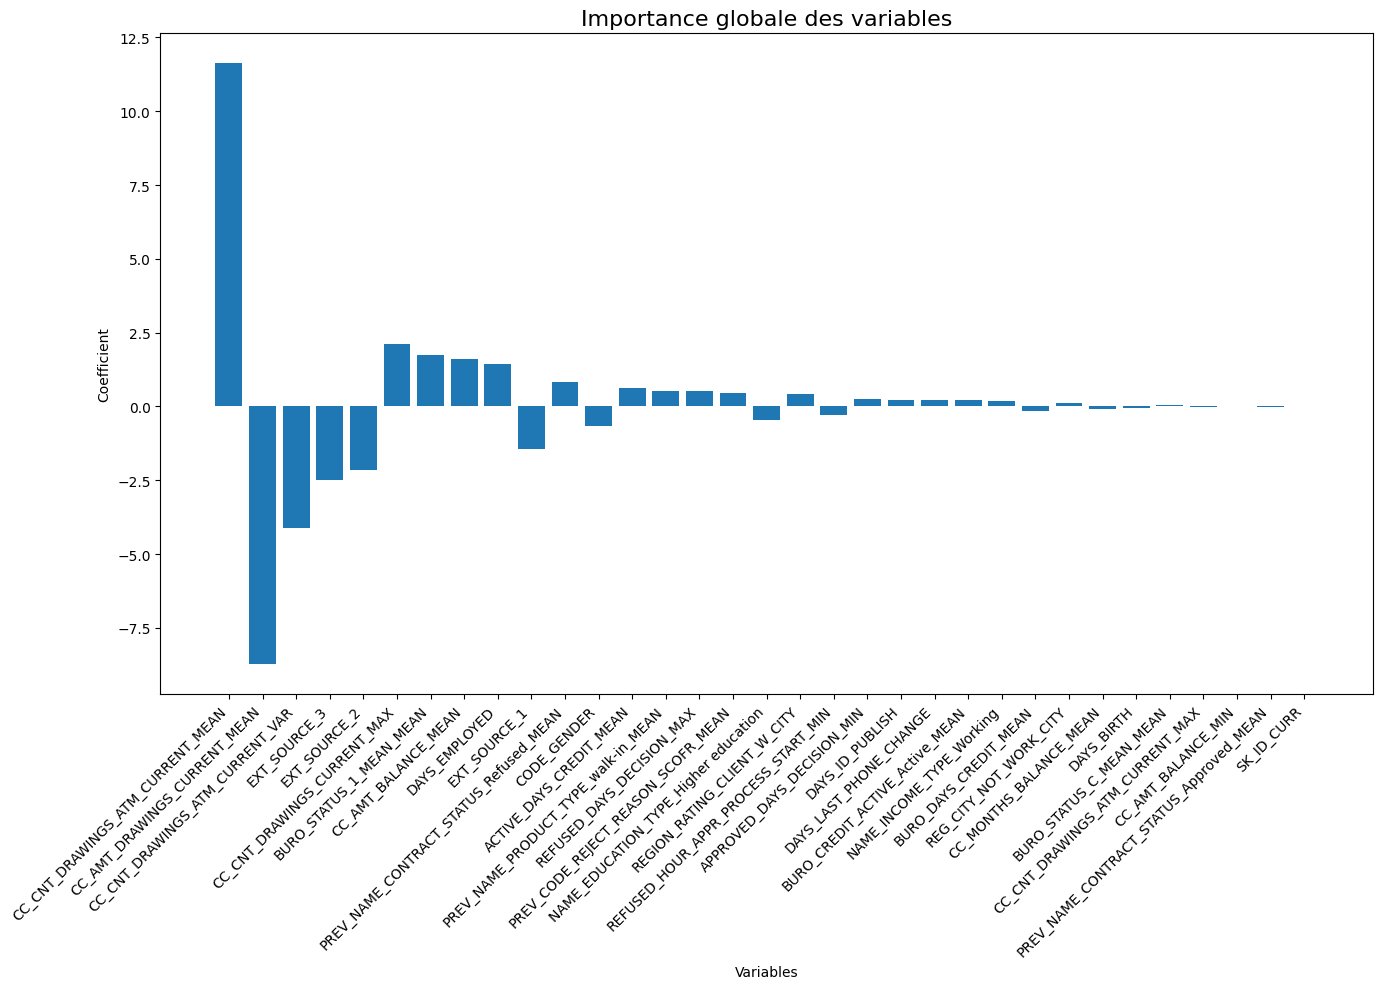

In [19]:
#Importance globale
# Récupérer les coefficients du modèle
coefficients = best_model.coef_[0]  # Les coefficients pour chaque caractéristique
features = X_train.columns if isinstance(X_train, pd.DataFrame) else quantitative_columns

# Trier les coefficients par importance absolue
indices = np.argsort(np.abs(coefficients))[::-1]

# Tracer l'importance des variables
plt.figure(figsize=(14, 10))
plt.title("Importance globale des variables", fontsize=16)
plt.bar(range(len(coefficients)), coefficients[indices], align="center")
plt.xticks(range(len(coefficients)), [features[i] for i in indices], rotation=45, ha="right")
plt.xlabel("Variables")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.show()


Interprétation :
Les coefficients positifs signifient que la variable a un effet positif sur la probabilité de l'événement cible (c'est-à-dire, elle augmente la probabilité d'une prédiction positive).
Les coefficients négatifs signifient que la variable réduit la probabilité de l'événement cible.
La valeur absolue des coefficients indique l'importance des variables.

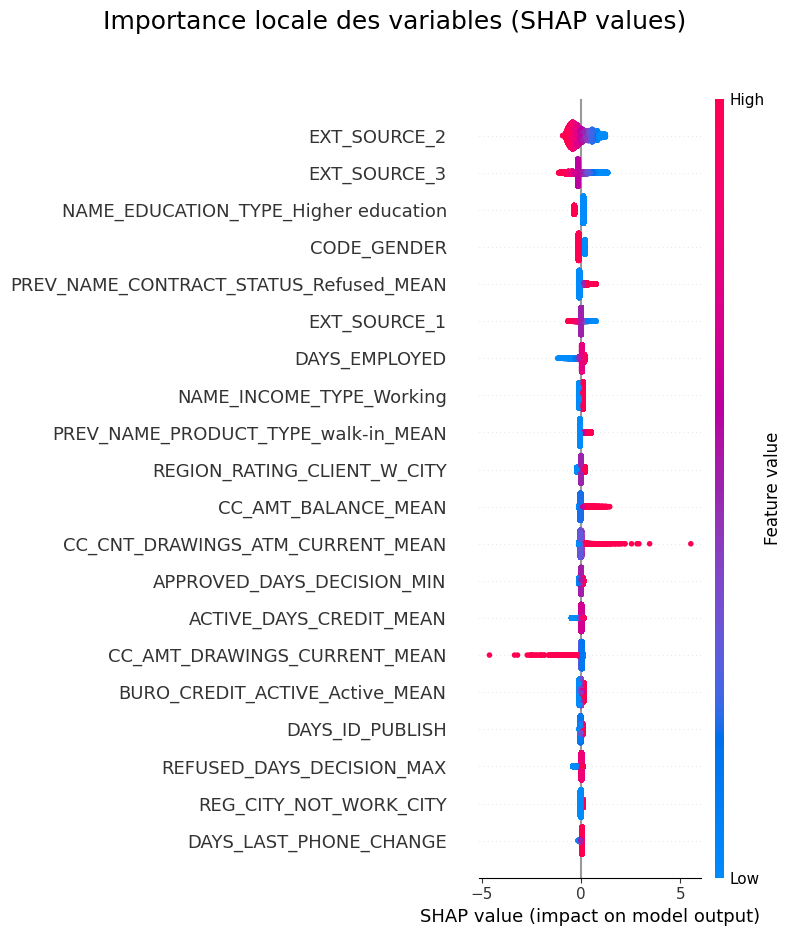

In [25]:
#Importance locale 
import shap

# Créer un explainer SHAP pour le modèle LogisticRegression
explainer = shap.LinearExplainer(best_model, X_train)  # Utilise l'explicateur linéaire pour la régression logistique

# Calculer les valeurs SHAP pour le jeu de test
shap_values = explainer.shap_values(X_test)

# Créer une nouvelle figure
plt.figure(figsize=(10, 6))

# Afficher le résumé SHAP global (mélange entre importance globale et locale)
shap.summary_plot(shap_values, X_test, feature_names=quantitative_columns, show=False)

# Ajouter un titre centré avec du padding pour éviter les décalages
plt.suptitle("Importance locale des variables (SHAP values)", x=0.5, ha='center', fontsize=18)

# Ajuster le layout pour éviter les chevauchements
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Afficher la figure
plt.show()

Globalement, les variables les plus importantes sont celles en haut du graphique.
Localement, chaque point montre l'impact d'une variable spécifique pour un individu donné, ce qui permet de voir comment les valeurs individuelles affectent les prédictions du modèle.

Valeurs SHAP (axe horizontal) :
L'axe des abscisses (X) représente les valeurs SHAP. Plus la valeur SHAP d'une variable est éloignée de zéro, plus cette variable a un fort impact sur la prédiction (positivement ou négativement).
Les points à droite (valeurs SHAP positives) indiquent que la variable a contribué à augmenter la probabilité du modèle de prédire la classe positive.
Les points à gauche (valeurs SHAP négatives) indiquent que la variable a contribué à diminuer cette probabilité.

Couleurs des points :
Chaque point représente une observation (un individu du jeu de test).
La couleur des points indique la valeur de la variable pour cet individu :
Rouge = Valeurs élevées de la variable.
Bleu = Valeurs basses de la variable.
Par exemple, pour la variable EXT_SOURCE_2, on observe que des valeurs élevées ont tendance à réduire la probabilité du modèle de prédire la classe positive (les points rouges sont vers la gauche).

EXT_SOURCE_2 et EXT_SOURCE_3 : Ces deux variables semblent être les plus influentes. Les points rouges sont principalement situés à gauche, indiquant que des valeurs élevées réduisent les prédictions positives.
NAME_EDUCATION_TYPE_Higher education : On voit que cette variable a un effet varié. Des valeurs élevées (rouge) ont tendance à augmenter la probabilité de la classe positive.
CODE_GENDER : La couleur semble indiquer que le genre a un certain impact, mais cet impact est moins marqué que celui des autres variables plus haut dans la liste.

Le graphique montre que certaines variables, notamment EXT_SOURCE_2, EXT_SOURCE_3, et le niveau d'éducation, jouent un rôle clé dans les décisions du modèle.

In [42]:
import joblib

# Sauvegarder le modèle dans un fichier
joblib.dump(best_model, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

In [43]:
import joblib
joblib.dump(best_model, 'model.joblib')

['model.joblib']